In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers

import numpy as np
import math

In [2]:
!pip install enformer-pytorch #Need to install so can load pretrained weights into the architecture later defined below and compare to Lucidrains' implementation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 5.8 MB/s eta 0:00:00


In [3]:
#Note: If possible, use high-ram CPU on colab (requires fewer credits then GPU but suitable to run the code below relatively quick)
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(device)

cpu


NOTE: To test whether the below implementation is correct, it requires mapping the weights from a pre-trained variant of Enformer to the below step-step implementation and determining whether it provides an equivalent output to the pretrained Enformer. To allow for weights to be mapped easily from the pre-trained variant, I will be using the same overall structure as Lucidrains': https://github.com/lucidrains/enformer-pytorch


Focusing on Figure A, the transformer architecture can be defined as followed ...

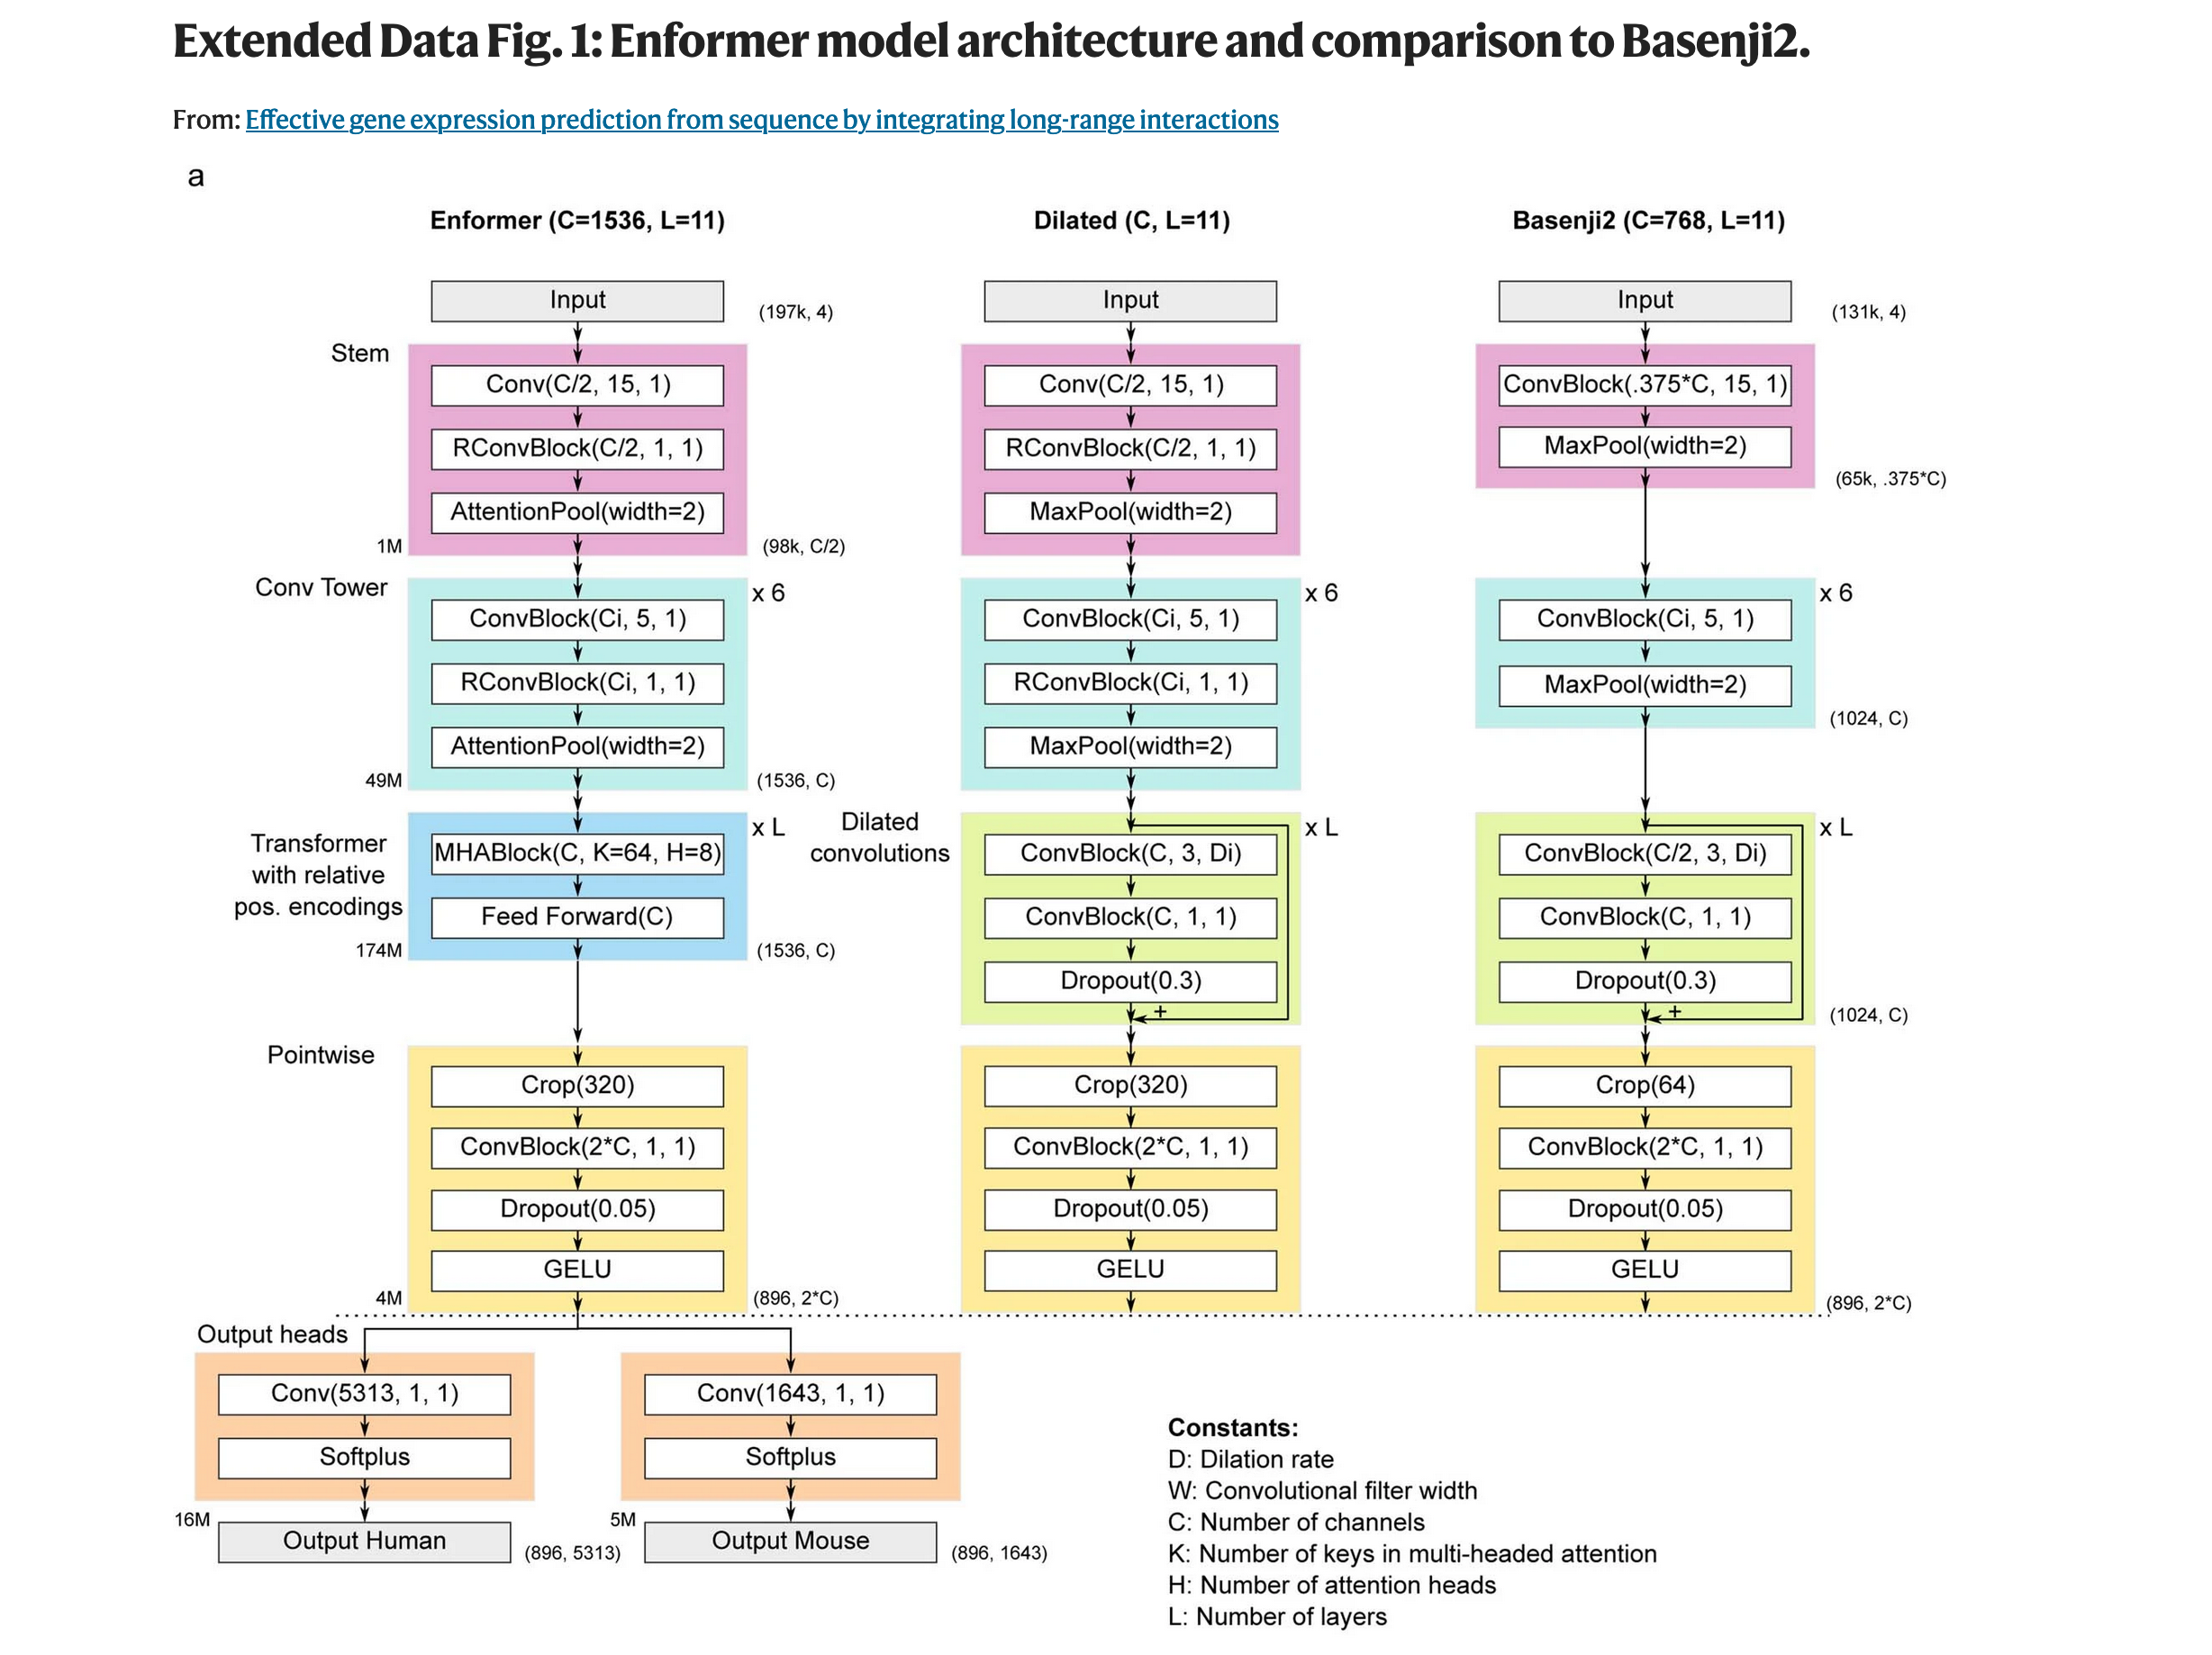

In [ ]:
#B = Number of Batches
#C = Number of Channels
#N = Number of elements in Sequence

Focusing on the 1) STEM
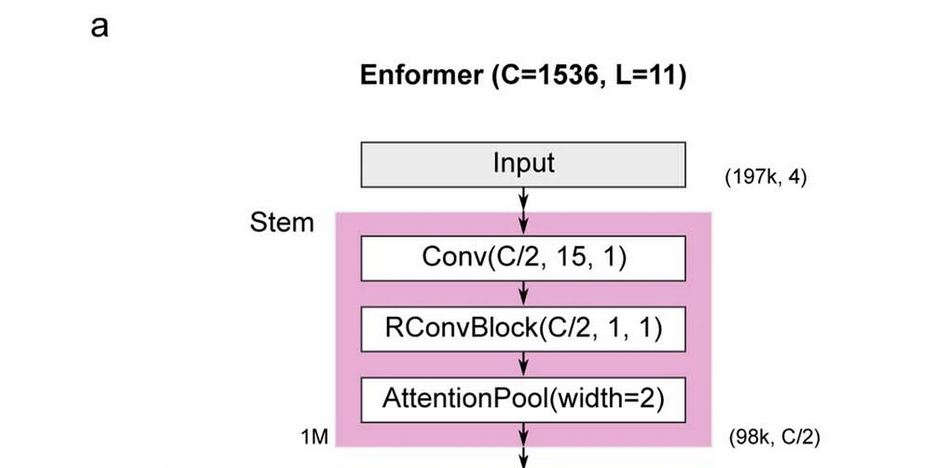

In [ ]:
""" Google's Enformer uses the below approximation for the Gelu activation function"""
class GELU(nn.Module):
  def forward(self, x):
    return torch.sigmoid(1.702 * x) * x

ConvBlock and RConvBlock as defined as followed...
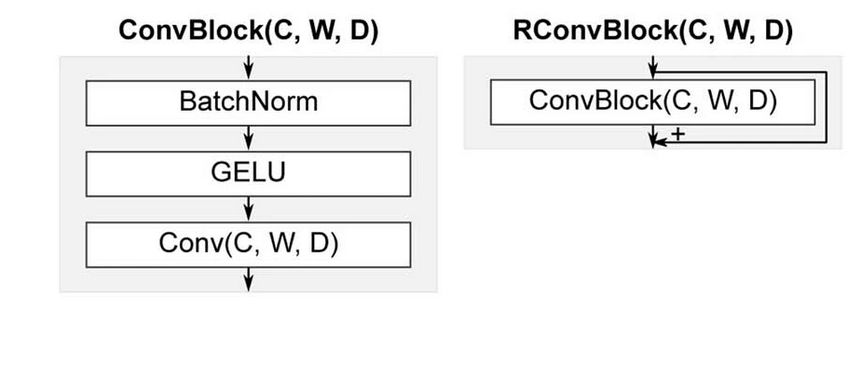

In [ ]:
#Input Shape: B,C,N
def conv_block(input_channels, output_channels, kernel_size):
    return nn.Sequential(nn.BatchNorm1d(input_channels), GELU(), nn.Conv1d(input_channels, output_channels, kernel_size, padding = "same"))

In [ ]:
#Input Shape: B,C,N
class rconv(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return x + self.fn(x)

One change in Enformer, relative to predecessors, which was important to it's improved performance was the use of **AttentionPooling**. Below is one such implementation. For an alternative (and more efficient) implementation, check out Lucidrains's repository

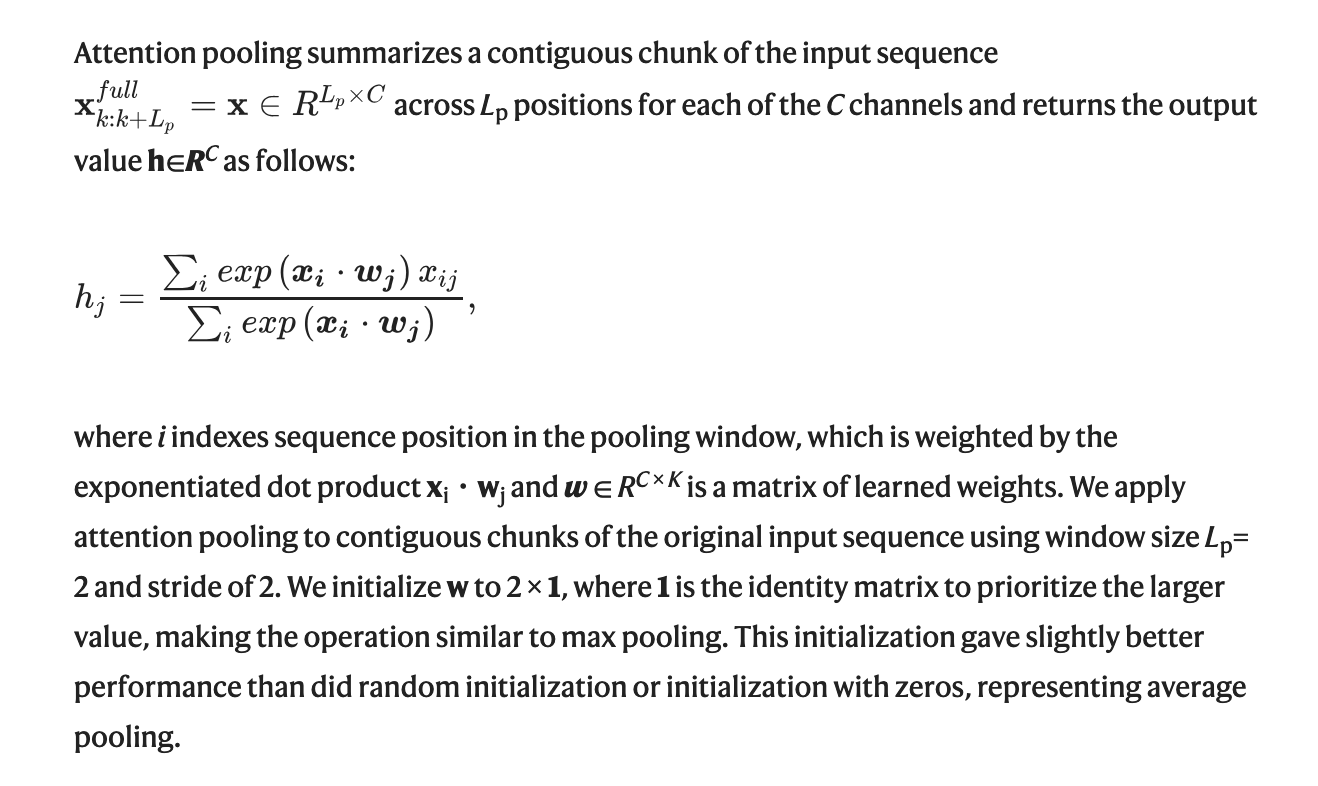

In [ ]:
#Input Shape: B,C,N
class AttentionPool(nn.Module):
    def __init__(self, num_channels, window_size):
        super().__init__()
        self.to_attn_logits = nn.Parameter(2*torch.eye(num_channels))
        self.window_size = window_size

    def forward(self, x):
        x = x.permute(0,2,1)
        B,N,C = x.shape

        if N%self.window_size != 0:
            pad_amount = N%self.window_size
            min_value = -float("inf")
            x = F.pad(x, (0, 0, 0, pad_amount), value = min_value)
        else:
            pad_amount = 0

        num_strides = (B*(N+pad_amount)*C)//(self.window_size*C) * self.window_size*C
        window_indices = torch.concatenate([torch.arange(i, i + C*self.window_size) for i in range(0, B*(N+pad_amount)*C, self.window_size*C)], dim = 0)[:num_strides]
        x = x.contiguous().view(-1)[window_indices]
        x = x.view(B, -1, self.window_size, C)

        if pad_amount != 0:
            att_inputs = (x.masked_fill(x == min_value , 0)) @ self.to_attn_logits
            att = F.softmax(att_inputs.masked_fill(x == min_value , min_value), dim = 2)
            x = torch.where(x == min_value, 0., x)
        else:
            att = F.softmax(x @ self.to_attn_logits, dim = 2)

        x = (att*x).sum(dim = 2)

        return x[:,:(N - pad_amount),:].permute(0,2,1)

Focusing on 2)CONV TOWER 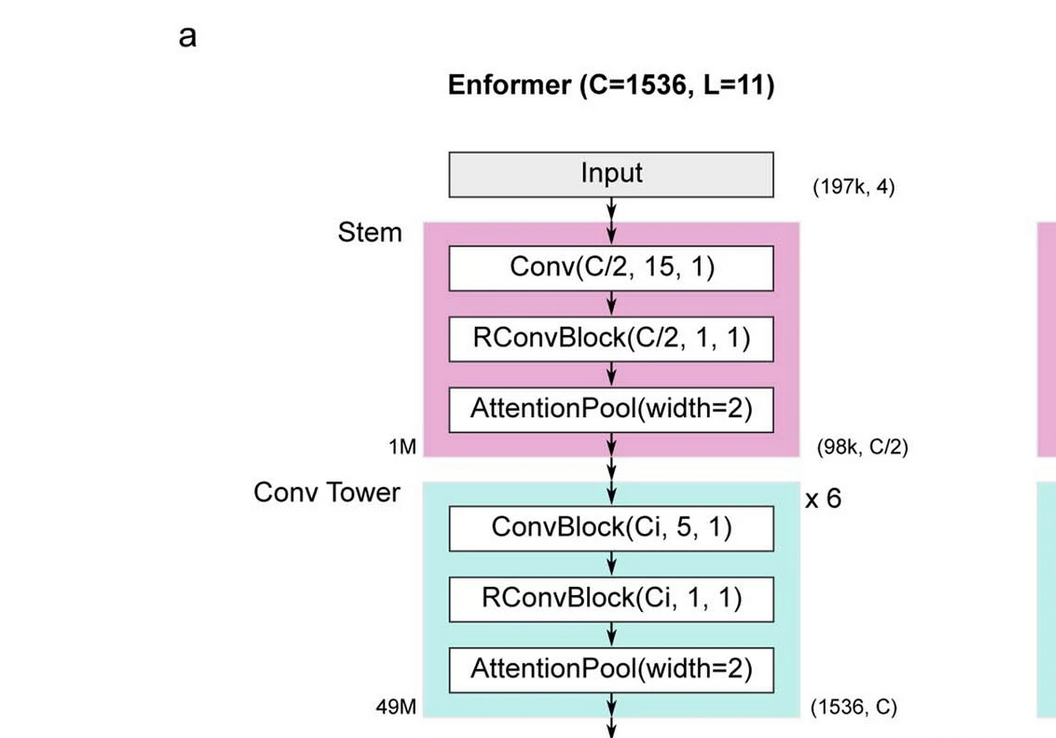

The function below is needed to determine the number of output channels used in each convtower block

In [ ]:
#Function can be found at: https://github.com/google-deepmind/deepmind-research/blob/f5de0ede8430809180254ee957abf36ed62579ef/enformer/enformer.py#L328

def get_num_channels(start, end, num, divisible_by=128):
    def _round(x):
        return int(np.round(x/divisible_by) * divisible_by)
    base = np.exp(np.log(end / start) / (num - 1))
    return [_round(start * base**i) for i in range(num)]

In [ ]:
# !wget "https://github.com/lucidrains/enformer-pytorch/blob/main/enformer_pytorch/precomputed/tf_gammas.pt"

At the end of the ConvTower, will have B,C,1536 (assuming input was 19K), where each of the elements in the sequence (along length dim) represents 128 bp (128x1536 = 19K)

Focusing on 3)TRANSFORMER BLOCKS
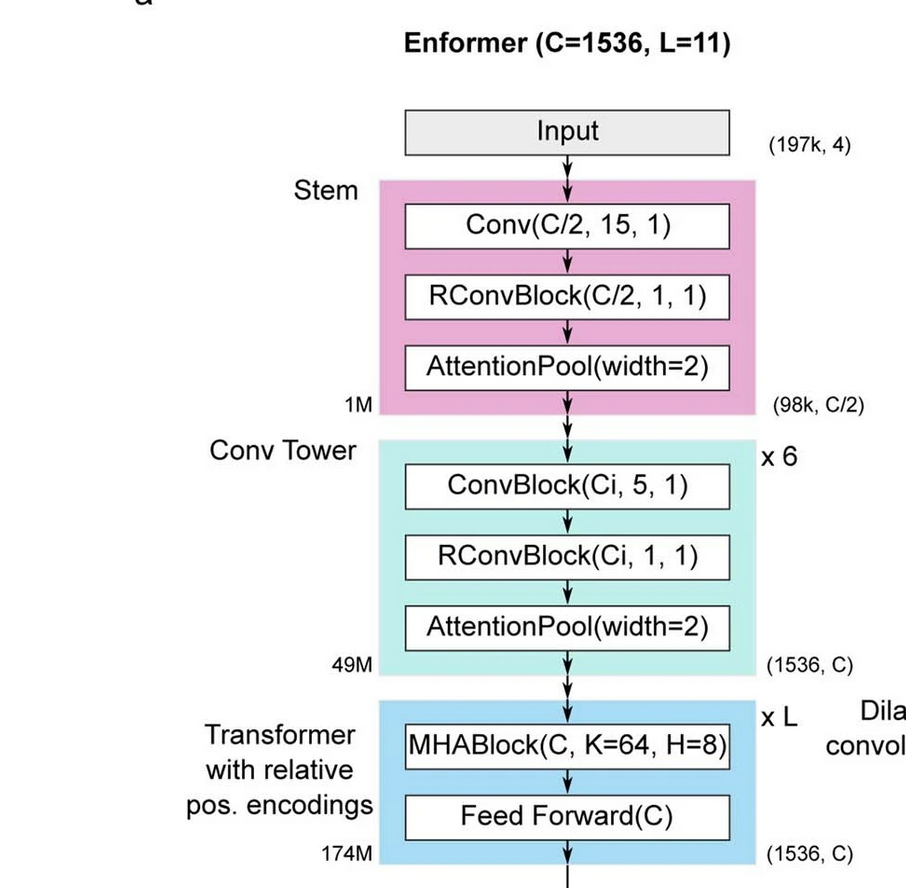

In [ ]:
#Due to differences between tensorflow and pytorch `xlogy`, need to load in precomputed gamma positions when using input of 196,608 bp
#Download it from https://github.com/lucidrains/enformer-pytorch/blob/main/enformer_pytorch/precomputed/tf_gammas.pt and upload to colab; I tried wget but the file gets corrupted for some reason
TF_GAMMAS = torch.load("/content/tf_gammas.pt")

<ipython-input-13-218e782182ed>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  TF_GAMMAS = torch.load("/content/tf_gammas.pt")


Another important advancement in the Enformer architecture was the use of relative positional encodings. Their application of relative positional encodings took significant inspiration from the Transformer-XL approach: https://arxiv.org/abs/1901.02860

Below, I'll provide a minimal implementation which highlights how...

1) relative encodings are computed for each query-key pair

2) directionality is incorporated within the encodings to differentiate between positions upstream and downstream of TSS

In particular, the focus will be on the central_mask basis function, since it is both the most useful of three functions for positional encoding  and it was also the only function used in Enformer's successor (Borzoi)

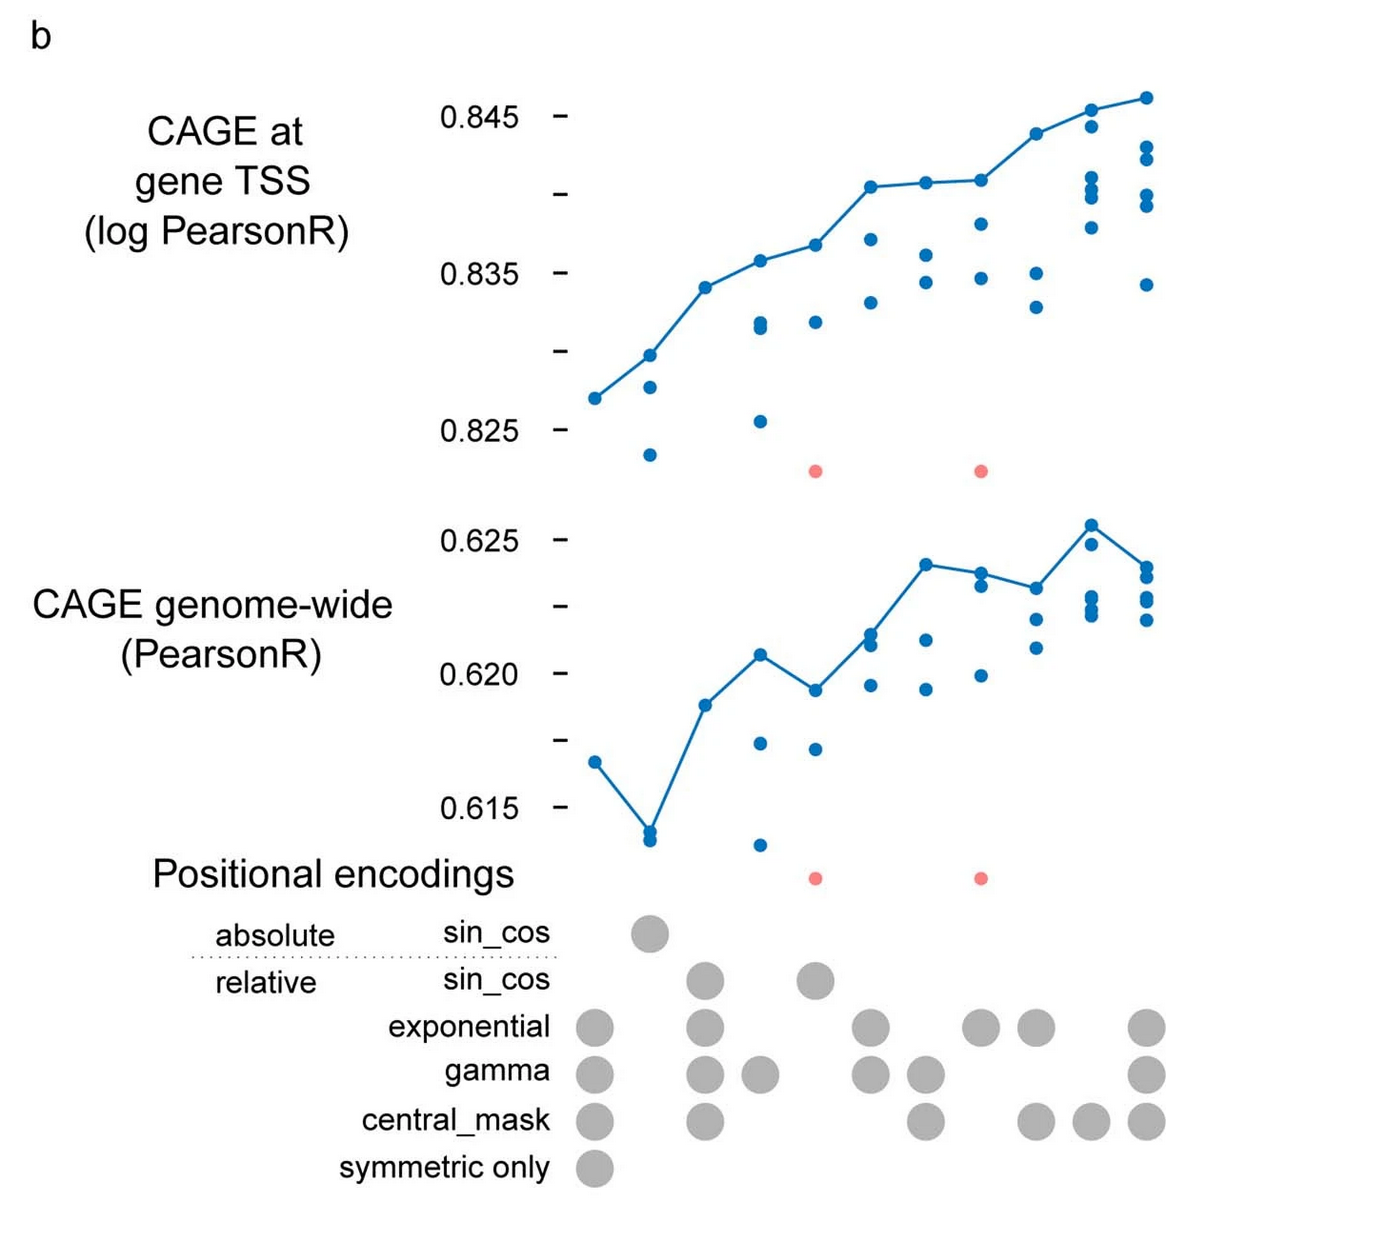

In [4]:
#Defining the basis function
def central_mask(rel_positions, num_features, seq_len, dtype = torch.float):
    exp_values = 2 ** torch.arange(1, num_features + 1, device = rel_positions.device).to(dtype)
    exp_values = exp_values - 1
    return (exp_values[None,:] > rel_positions.abs()[:, None]).to(dtype)

#Function to get positional encodings
def get_ct_mask_embed(seq_len, num_features, device, dtype = torch.float):
    rel_positions = torch.arange(-seq_len + 1, seq_len, device = device) #We want positional features for -seq_len + 1 to seq_len, i.e -1535 to 1535
    embeddings = (central_mask(rel_positions, num_features, seq_len, dtype = dtype))
    embeddings = torch.cat((embeddings, embeddings), dim = -1) #This is important for generating relative encodings for query-key pair
    return embeddings.to(dtype)

input = torch.randn(1,1536,128) #Typical input size to Transformer Block, where in MHA block will be shape of B,N,C
pos_features = get_ct_mask_embed(input.shape[1], 32, 'cpu')
print(f"Shape of positional features is {pos_features.shape}")

Shape of positional features is torch.Size([3071, 64])


Note: it is important to recognize that rows 0 to 3070 in the positional features can be mapped to the relative positions -1535 to 1535 (i.e 0 to -1535, 1535 to 0, 3070 to +1535)

Now the pos_features are transformed through matrix multiplication to alter its dimensions such that we can generate location/position based key vectors which are compatible with the dimensions of the queries in MHA. For simplicity, we use num_heads = 1

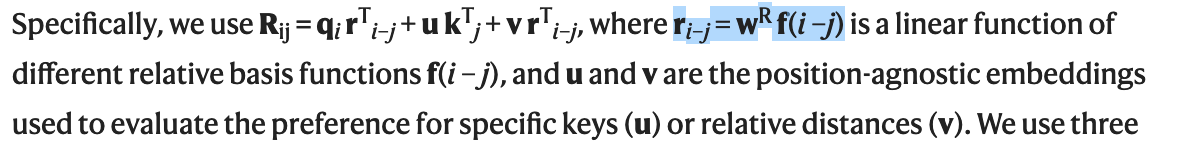

In [5]:
transformed_pos_features = pos_features @ torch.randn(64,128)
print(f"Shape of transformed positional features is {transformed_pos_features.shape}")

Shape of transformed positional features is torch.Size([3071, 128])


Let's compute the positional logits, which when combined with the content logits, will be used to compute the attention matrix. For simplicity, I will be ignoring *v*, a set of trainable parameters used to evaluate preferences for relative distance, and only focusing on the unaltered query tensor

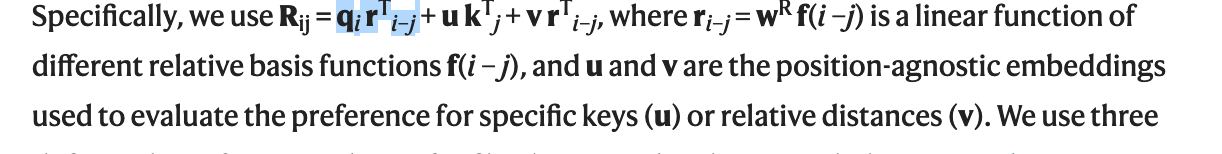

In [6]:
ex_query = torch.randn(1,1,1536,128)
pos_logits = ex_query @ transformed_pos_features[None,None,:,:].permute(0,1,3,2)
print(f"Shape of positional logits is {pos_logits.shape}")

Shape of positional logits is torch.Size([1, 1, 1536, 3071])


However, a clear problem with the above positional logits, is that the matrix needs to be NxN since both query and key are derived from the same sequence. Right now, we have N querys, and Nx2-1 keys

One solution to resolve this is to use index the positional logits as follows...

In [7]:
pos_logits[...,:1536].shape

torch.Size([1, 1, 1536, 1536])

However, this is not sufficient, as we want this positional logits matrix to have the property where w.r.t to query i (row i), at column i, it has the key with a relative position j such that i == j

This is a mouthful, so I'll try to explain it through some tensor operations below. To do so, I will create a matrix of an equivalent size to pos_logits, but instead of the tensor being composed of logits for query i and key j, it is instead filled with the relative position of key j

In [8]:
rel_pos_mtx = torch.arange(-input.shape[1] + 1, input.shape[1]).repeat(input.shape[1],1)
print(rel_pos_mtx)
print(rel_pos_mtx.shape)

tensor([[-1535, -1534, -1533,  ...,  1533,  1534,  1535],
        [-1535, -1534, -1533,  ...,  1533,  1534,  1535],
        [-1535, -1534, -1533,  ...,  1533,  1534,  1535],
        ...,
        [-1535, -1534, -1533,  ...,  1533,  1534,  1535],
        [-1535, -1534, -1533,  ...,  1533,  1534,  1535],
        [-1535, -1534, -1533,  ...,  1533,  1534,  1535]])
torch.Size([1536, 3071])


Now if I cut it in half...

In [9]:
rel_pos_mtx_wrong = rel_pos_mtx[...,:1536]
print(rel_pos_mtx_wrong)

tensor([[-1535, -1534, -1533,  ...,    -2,    -1,     0],
        [-1535, -1534, -1533,  ...,    -2,    -1,     0],
        [-1535, -1534, -1533,  ...,    -2,    -1,     0],
        ...,
        [-1535, -1534, -1533,  ...,    -2,    -1,     0],
        [-1535, -1534, -1533,  ...,    -2,    -1,     0],
        [-1535, -1534, -1533,  ...,    -2,    -1,     0]])


Looking above, for query 0, if we look at key 0, we can see that relative position of key 0 is -1535. However, this does not make sense, since both query and key are derived from the same sequence, and so the relative distance of query 0 (bin 0) to key 0 (bin 0) should be 0; thus key 0 needs to correspond with the key pertaining to relative positon 0

Likewise for query 1, if we look at key 0, the relative position of key 0 used to compute the logit at pos_logits[:,:,1,0] should be relative position -1, since bin 0 (key 0) is -1 relative to bin 1 (query 1), but instead the key corresponding to relative position -1535 was still used

To correct this, the Transformer-XL group uses the below function ...

In [10]:
def relative_shift(pos_embd):
    pos_embd = torch.cat((torch.zeros_like(pos_embd[..., :1]), pos_embd), dim = -1)
    B,H,N1,N2 = pos_embd.shape
    pos_embd = pos_embd.view(B, H, N2, N1)
    pos_embd = pos_embd[:, :, 1:, :]
    pos_embd = pos_embd.view(B, H, N1, N2 - 1)
    return pos_embd[..., :((N2 + 1) // 2)]

rel_pos_mtx_correct = relative_shift(rel_pos_mtx[None,None,...])
print(rel_pos_mtx_correct)

tensor([[[[    0,     1,     2,  ...,  1533,  1534,  1535],
          [   -1,     0,     1,  ...,  1532,  1533,  1534],
          [   -2,    -1,     0,  ...,  1531,  1532,  1533],
          ...,
          [-1533, -1532, -1531,  ...,     0,     1,     2],
          [-1534, -1533, -1532,  ...,    -1,     0,     1],
          [-1535, -1534, -1533,  ...,    -2,    -1,     0]]]])


Here, we can see for query 0, key 0 now corresponds to the key with a relative position of 0. Similarly, for query 1, key 0 now corresponds with a relative positon of -1. Now lets compute the positional logits

In [ ]:
pos_logits = relative_shift(pos_logits)
print(pos_logits.shape)

torch.Size([1, 1, 1536, 1536])


However, one important problem that still exists in the pos_logits, is that directionality is not incorporated within the postional encoding, where for instance for query 768, which is the middle of the sequence, both key 0 and key 1535 (which respectively corresponds to relative position -768 and 768) will generate the same output with query 768

In [ ]:
pos_logits[:,:,768,0] == pos_logits[:,:,768,1535]

tensor([[True]])

We don't want that, and instead we want introduce directionality to inform the model, what is upstream and downstream of the TSS. To do so we concate the original basis features, with the basis features * relative number signs

In [ ]:
def get_ct_mask_embed(seq_len, num_features, device, dtype = torch.float):
    rel_positions = torch.arange(-seq_len + 1, seq_len, device = device)
    embeddings = (central_mask(rel_positions, num_features, seq_len, dtype = dtype))
    embeddings = torch.cat((embeddings, torch.sign(rel_positions)[:,None] * embeddings), dim = -1) #here we are concatenating the original basis features with basis features * relative number sings
    return embeddings.to(dtype)

pos_features = get_ct_mask_embed(input.shape[1], 32, 'cpu')
transformed_pos_features = pos_features @ torch.randn(64,128)
pos_logits = ex_query @ transformed_pos_features[None,None,:,:].permute(0,1,3,2)
pos_logits = relative_shift(pos_logits)

Now, directionality is incorporated, and query 768 should have different logits with key 0 and key 1535

In [ ]:
pos_logits[:,:,768,0] == pos_logits[:,:,768,1535]

tensor([[False]])

In [ ]:
#All the below code is add the exponential and gamma basis function to the above ...
#Note, the code in this cell is copied verbatim from Lucidrain's repository

def exists(val):
    return val is not None

def always(val):
    def inner(*args, **kwargs):
        return val
    return inner

def get_positional_features_exponential(positions, features, seq_len, min_half_life = 3., dtype = torch.float):
    max_range = math.log(seq_len) / math.log(2.)
    half_life = 2 ** torch.linspace(min_half_life, max_range, features, device = positions.device)
    half_life = half_life[None, ...]
    positions = positions.abs()[..., None]
    return torch.exp(-math.log(2.) / half_life * positions)

def get_positional_features_central_mask(positions, features, seq_len, dtype = torch.float):
    center_widths = 2 ** torch.arange(1, features + 1, device = positions.device).to(dtype)
    center_widths = center_widths - 1
    return (center_widths[None, ...] > positions.abs()[..., None]).to(dtype)

def gamma_pdf(x, concentration, rate):
    log_unnormalized_prob = torch.xlogy(concentration - 1., x) - rate * x
    log_normalization = (torch.lgamma(concentration) - concentration * torch.log(rate))
    return torch.exp(log_unnormalized_prob - log_normalization)

def get_positional_features_gamma(positions, features, seq_len, stddev = None, start_mean = None, eps = 1e-8, dtype = torch.float):
    if not exists(stddev):
        stddev = seq_len / (2 * features)

    if not exists(start_mean):
        start_mean = seq_len / features

    mean = torch.linspace(start_mean, seq_len, features, device = positions.device)

    mean = mean[None, ...]
    concentration = (mean / stddev) ** 2
    rate = mean / stddev ** 2

    probabilities = gamma_pdf(positions.to(dtype).abs()[..., None], concentration, rate)
    probabilities = probabilities + eps
    outputs = probabilities / torch.amax(probabilities, dim = -1, keepdim = True)
    return outputs

def get_positional_embed(seq_len, feature_size, device, use_tf_gamma, dtype = torch.float):
    distances = torch.arange(-seq_len + 1, seq_len, device = device)

    assert not use_tf_gamma or seq_len == 1536, 'if using tf gamma, only sequence length of 1536 allowed for now'

    feature_functions = [
        get_positional_features_exponential,
        get_positional_features_central_mask,
        get_positional_features_gamma if not use_tf_gamma else always(TF_GAMMAS.to(device))
    ]

    num_components = len(feature_functions) * 2

    if (feature_size % num_components) != 0:
        raise ValueError(f'feature size is not divisible by number of components ({num_components})')

    num_basis_per_class = feature_size // num_components

    embeddings = []
    for fn in feature_functions:
        embeddings.append(fn(distances, num_basis_per_class, seq_len, dtype = dtype))

    embeddings = torch.cat(embeddings, dim = -1)
    embeddings = torch.cat((embeddings, torch.sign(distances)[..., None] * embeddings), dim = -1)
    return embeddings.to(dtype)

In [ ]:
def relative_shift(pos_embd):
    pos_embd = torch.cat((torch.zeros_like(pos_embd[..., :1]), pos_embd), dim = -1)
    B,H,N1,N2 = pos_embd.shape
    pos_embd = pos_embd.view(B, H, N2, N1)
    pos_embd = pos_embd[:, :, 1:, :]
    pos_embd = pos_embd.view(B, H, N1, N2 - 1)
    return pos_embd[..., :((N2 + 1) // 2)]

Below is a relatively normal implementation of MHA, with differences primarily pertaining the inclusion of the Transformer-XL positional encodings. MHABlock is defined as followed...

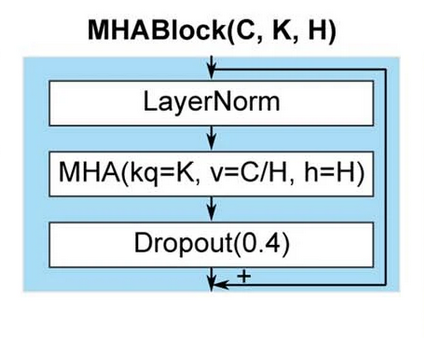

In [ ]:
#Input Shape: B,N,C
class MHA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.rel_content_bias = nn.Parameter(torch.randn(1, config.num_heads, 1, config.qk_dim))
        self.rel_pos_bias = nn.Parameter(torch.randn(1, config.num_heads, 1, config.qk_dim))
        self.to_q = nn.Linear(config.num_channels, config.num_heads*config.qk_dim, bias = False)
        self.to_k = nn.Linear(config.num_channels, config.num_heads*config.qk_dim, bias = False)
        self.to_v = nn.Linear(config.num_channels, config.num_channels, bias = False)
        self.to_rel_k = nn.Linear(config.num_channels//config.num_heads, config.num_heads*config.qk_dim, bias = False)
        self.to_out = nn.Linear(config.num_channels, config.num_channels)

        self.num_heads = config.num_heads
        self.qk_dim = config.qk_dim
        self.use_precomputed = True

    def use_precomputed(self, use_precomputed):
        self.use_precomputed = use_precomputed

    def forward(self, x):
        B,N,C = x.shape
        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)

        q = q.view(B,N,self.num_heads,self.qk_dim).permute(0,2,1,3)
        q *= (self.qk_dim**-0.5)
        k = k.view(B,N,self.num_heads,self.qk_dim).permute(0,2,1,3)
        v = v.view(B,N,self.num_heads,C//8).permute(0,2,1,3)

        if N != 1536 or self.use_precomputed == False:
          use_tf_gamma = False
        else:
          use_tf_gamma = True

        logits =  q @ k.transpose(2,3)

        content = self.rel_content_bias @ k.transpose(2,3)
        logits += content

        positional_encodings = get_positional_embed(N, C//self.num_heads, device, use_tf_gamma)

        positional_encodings = F.dropout(positional_encodings, 0.01, training = self.training)

        position_keys = self.to_rel_k(positional_encodings).view(1, -1, self.num_heads, self.qk_dim).permute(0,2,3,1)
        position = (q + self.rel_pos_bias) @ position_keys

        position = relative_shift(position)
        logits += position
        att = F.softmax(logits, dim = -1)
        att = F.dropout(att, 0.05, training = self.training)

        pre_output = att @ v
        pre_output = pre_output.permute(0,2,1,3).contiguous().view(B,N,C)
        output = self.to_out(pre_output)

        return output


In [ ]:
#Input Shape: B,N,C
class MHA_block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fn = nn.Sequential(nn.LayerNorm(config.num_channels), MHA(config), nn.Dropout(0.4))

    def forward(self, x):
        return x + self.fn(x)

FeedForward block is defined as followed:

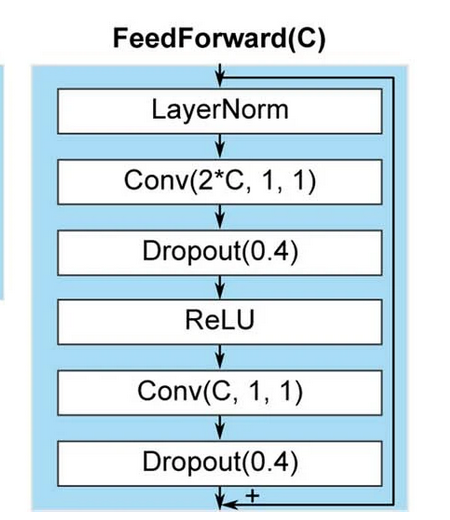

In [ ]:
#Input Shape: B,N,C
#Created to allow for easier transition from MHA block to FeedForward Block
class LayerNorm_permuted(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.in_channels = in_channels
    self.weight = nn.Parameter(torch.ones(in_channels))
    self.bias = nn.Parameter(torch.zeros(in_channels))

  def forward(self, x):
    B,T,C = x.shape
    x = self.weight*((x - x.mean(dim = -1, keepdim = True))/torch.sqrt(1e-5 + x.var(dim = -1, keepdim = True, correction = 0)))+self.bias
    return x.permute(0,2,1)

In [ ]:
#Input Shape: B,C,N
class FeedForward_block(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.fn = nn.Sequential(LayerNorm_permuted(num_channels), nn.Conv1d(num_channels, num_channels*2, kernel_size = 1), nn.Dropout(0.4), nn.ReLU(), nn.Conv1d(num_channels*2, num_channels, kernel_size = 1), nn.Dropout(0.4))
    def forward(self, x):
        return x + self.fn(x).permute(0,2,1)


Focusing on 4: Pointwise
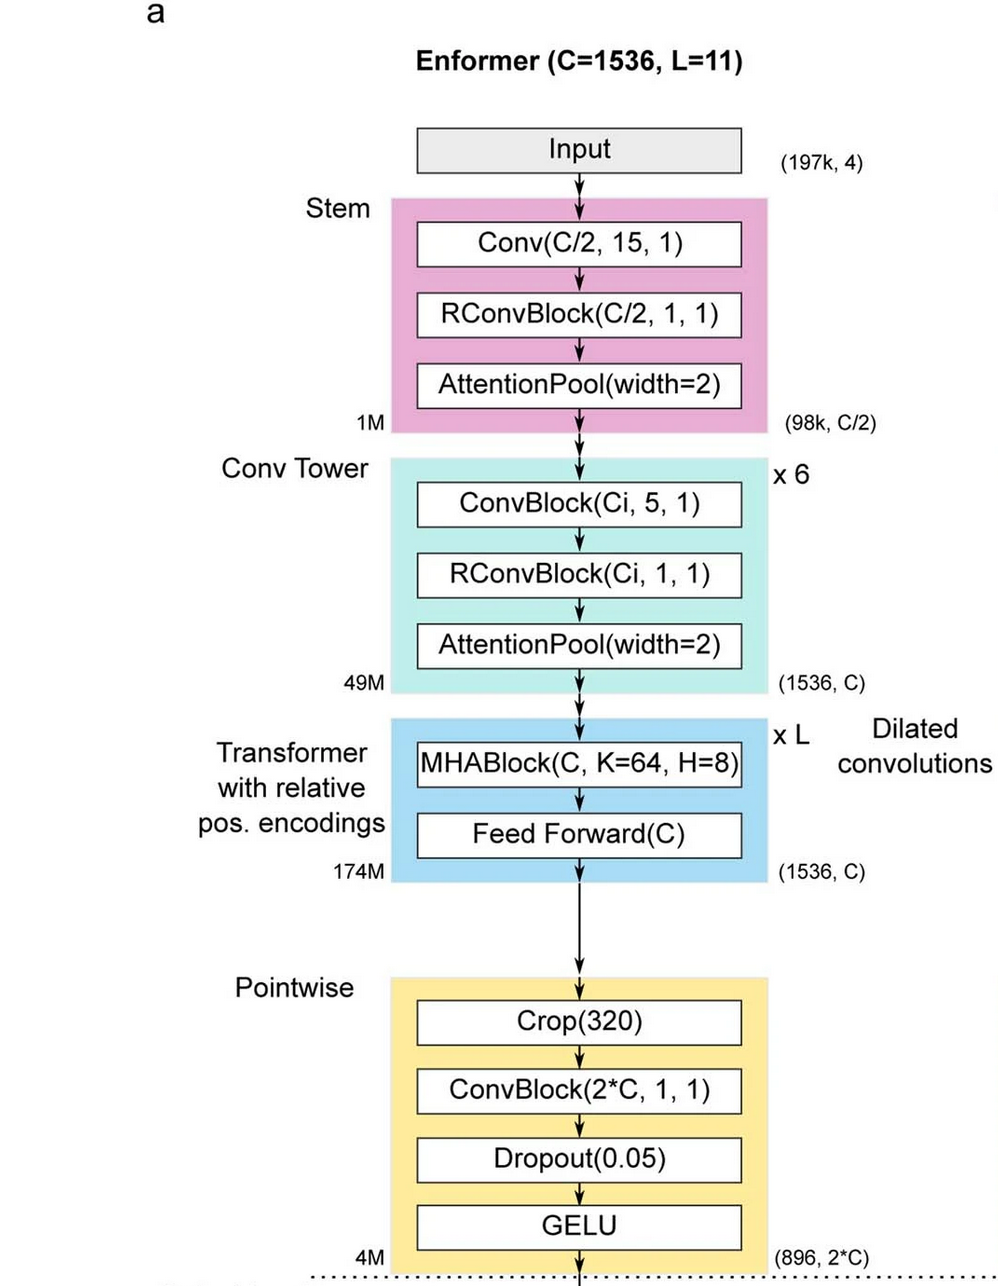


Within Enformer, the authors trimmed the sequence at the far ends, because the predictions generated are severely hampered, as only has access to one-side of the sequence (towards the center)

In [ ]:
class Cropping(nn.Module):
    def __init__(self, crop_len = 896): #Note: The above image highlights that 320 elements are cropped on each end such that the final N = 896
        super().__init__()
        self.crop_len = crop_len

    def forward(self, x):
        B,C,N = x.shape
        trim = (N - self.crop_len)//2
        return x[:, :, trim:-trim]

In [ ]:
class Enformer_config:
    def __init__(self, num_channels, num_conv_blocks, num_transformer_blocks, num_heads, qk_dim):
        self.num_channels = num_channels
        self.num_conv_blocks = num_conv_blocks
        self.num_transformer_blocks = num_transformer_blocks
        self.num_heads = num_heads
        self.qk_dim = qk_dim

Now, putting it all together...

In [ ]:
class Enformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.stem = nn.Sequential(nn.Conv1d(4, int(config.num_channels/2), 15, padding = "same"), rconv(conv_block(int(config.num_channels/2), int(config.num_channels/2), 1)), AttentionPool(int(config.num_channels/2),2))
        self.conv_tower_channels = [int(config.num_channels/2)] + get_num_channels(int(config.num_channels/2), config.num_channels, config.num_conv_blocks)
        self.conv_tower = nn.ModuleList([nn.Sequential(conv_block(in_c, out_c, 5), rconv(conv_block(out_c,  out_c, 1)), AttentionPool(out_c,2)) for in_c, out_c in zip(self.conv_tower_channels, self.conv_tower_channels[1:])])
        self.transformer = nn.ModuleList([nn.Sequential(MHA_block(config), FeedForward_block(config.num_channels)) for _ in range(config.num_transformer_blocks)])
        self.final_pointwise = nn.Sequential(Cropping(), conv_block(config.num_channels,2*config.num_channels,1), nn.Dropout(0.05), GELU())
        self._heads = nn.ModuleDict({"human": nn.Sequential(nn.Conv1d(2*config.num_channels,5313,1), nn.Softplus()), "mouse": nn.Sequential(nn.Conv1d(2*config.num_channels,1643,1), nn.Softplus())})

    def forward(self, x):
        #x.shape = B,C,N
        x = self.stem(x) #B,C,N
        for block in self.conv_tower:
            x = block(x) #B,C,N
        x = x.permute(0,2,1) #B,N,C
        for block in self.transformer:
            x = block(x) #B,N,C
        x = x.permute(0,2,1) #B,C,N
        x = self.final_pointwise(x) #B,C,N
        human_output = self._heads["human"](x) #B,5313,N
        mouse_output = self._heads["mouse"](x) #B,1643,N
        return {"human":human_output, "mouse":mouse_output}

    @classmethod
    def load_pretrained(self):
      config = Enformer_config(1536, 6, 11, 8, 64)
      model = Enformer(config)
      model_state_dict = model.state_dict()

      from enformer_pytorch import from_pretrained
      pretrained_model = from_pretrained('EleutherAI/enformer-official-rough')
      pretrained_model_state_dict = pretrained_model.state_dict()

      for k,v in model_state_dict.items():
        if k in pretrained_model_state_dict.keys() or "to_attn_logits" in k:
          if "to_attn_logits" in k:
            model_state_dict[k].copy_(pretrained_model_state_dict[k+".weight"].squeeze((-2,-1)).T)
          elif k in [f"transformer.{i}.1.fn.1.weight" for i in range(0, 12)] or k in [f"transformer.{i}.1.fn.4.weight" for i in range(0, 12)] or k in ["_heads.human.0.weight", "_heads.mouse.0.weight"]:
            model_state_dict[k].copy_(pretrained_model_state_dict[k].unsqueeze(-1))
          else:
            model_state_dict[k].copy_(pretrained_model_state_dict[k])

      return model

Now lets load the above implementation with the weights from Lucidrains' and compare it to the "unofficial PyTorch" variant from Lucidrain

In [ ]:
model = Enformer.load_pretrained()
model.to(device)

/usr/local/lib/python3.10/dist-packages/enformer_pytorch/modeling_enformer.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  TF_GAMMAS = torch.load(str(DIR / "precomputed

config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Enformer(
  (stem): Sequential(
    (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
    (1): rconv(
      (fn): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
      )
    )
    (2): AttentionPool()
  )
  (conv_tower): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(5,), stride=(1,), padding=same)
      )
      (1): rconv(
        (fn): Sequential(
          (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): GELU()
          (2): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
        )
      )
      (2): AttentionPool()
    )
    (1): Sequential(
      (0): Sequential(
        (0): BatchNorm1

In [ ]:
#Loading Lucidrains' implementation
from enformer_pytorch import from_pretrained, seq_indices_to_one_hot
pretrained_model = from_pretrained('EleutherAI/enformer-official-rough')
pretrained_model.to(device)

Enformer(
  (stem): Sequential(
    (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): Residual(
      (fn): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
    (2): AttentionPool(
      (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
      (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (conv_tower): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): Residual(
        (fn): Sequential(
          (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): GELU()
          (2): Conv1d(768, 768, kernel_size=(1,), stri

In [ ]:
#creating random data to compare outputs of models
torch.manual_seed(0)
seq = torch.randint(0, 4, (1, 196608))
one_hot_seq = F.one_hot(seq).to(torch.float32)
one_hot_seq = one_hot_seq.to(device)

In [ ]:
print(one_hot_seq, one_hot_seq.shape)

tensor([[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         ...,
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.]]]) torch.Size([1, 196608, 4])


In [ ]:
pretrained_model.eval()
pretrain_output = pretrained_model(one_hot_seq)

In [ ]:
model.eval()
output = model(one_hot_seq.permute(0,2,1))

In [ ]:
pretrain_output

{'human': tensor([[[0.0286, 0.0284, 0.0540,  ..., 0.0026, 0.0357, 0.0287],
          [0.0348, 0.0261, 0.0481,  ..., 0.0032, 0.0528, 0.0455],
          [0.0345, 0.0299, 0.0571,  ..., 0.0021, 0.0427, 0.0269],
          ...,
          [0.0208, 0.0231, 0.0495,  ..., 0.0010, 0.0167, 0.0116],
          [0.0216, 0.0232, 0.0484,  ..., 0.0030, 0.0294, 0.0300],
          [0.0194, 0.0202, 0.0446,  ..., 0.0012, 0.0114, 0.0101]]],
        grad_fn=<SoftplusBackward0>),
 'mouse': tensor([[[0.0207, 0.0574, 0.0421,  ..., 0.1016, 0.0818, 0.1753],
          [0.0266, 0.0754, 0.0547,  ..., 0.1044, 0.0899, 0.1786],
          [0.0603, 0.1180, 0.0742,  ..., 0.1084, 0.1076, 0.1896],
          ...,
          [0.0247, 0.0488, 0.0417,  ..., 0.0792, 0.0824, 0.1509],
          [0.0205, 0.0512, 0.0358,  ..., 0.0882, 0.1200, 0.1634],
          [0.0160, 0.0488, 0.0263,  ..., 0.0546, 0.0609, 0.0958]]],
        grad_fn=<SoftplusBackward0>)}

In [ ]:
output
#Can see our model output has the same logits as lucidrain's, just needs to transpose length and channel dimensions

{'human': tensor([[[0.0286, 0.0348, 0.0345,  ..., 0.0208, 0.0216, 0.0194],
          [0.0284, 0.0261, 0.0299,  ..., 0.0232, 0.0232, 0.0202],
          [0.0540, 0.0481, 0.0571,  ..., 0.0495, 0.0484, 0.0446],
          ...,
          [0.0026, 0.0032, 0.0021,  ..., 0.0010, 0.0030, 0.0012],
          [0.0357, 0.0528, 0.0427,  ..., 0.0167, 0.0294, 0.0114],
          [0.0287, 0.0455, 0.0269,  ..., 0.0116, 0.0300, 0.0101]]],
        grad_fn=<SoftplusBackward0>),
 'mouse': tensor([[[0.0207, 0.0266, 0.0603,  ..., 0.0247, 0.0205, 0.0160],
          [0.0574, 0.0754, 0.1180,  ..., 0.0488, 0.0512, 0.0488],
          [0.0421, 0.0547, 0.0742,  ..., 0.0417, 0.0358, 0.0263],
          ...,
          [0.1016, 0.1044, 0.1084,  ..., 0.0792, 0.0882, 0.0546],
          [0.0818, 0.0899, 0.1076,  ..., 0.0824, 0.1200, 0.0609],
          [0.1753, 0.1786, 0.1896,  ..., 0.1509, 0.1634, 0.0958]]],
        grad_fn=<SoftplusBackward0>)}

In [ ]:
torch.allclose(pretrain_output["human"], output["human"].permute(0,2,1), rtol = 1e-03)

True

In [ ]:
torch.allclose(pretrain_output["mouse"], output["mouse"].permute(0,2,1), rtol = 1e-03)

True

The above was comparing the two models on random data, now lets' compare it on actual sequence data and see if we can get the same loss

In [ ]:
#can get data from: https://github.com/lucidrains/enformer-pytorch/blob/main/data/test-sample.pt

/usr/local/lib/python3.10/dist-packages/enformer_pytorch/modeling_enformer.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  TF_GAMMAS = torch.load(str(DIR / "precomputed

In [ ]:
data = torch.load("/content/test-sample.pt", map_location=torch.device('cpu'))
data["sequence"].shape

<ipython-input-22-73528a1e7b00>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("/content/test-sample.pt", map_location=torch.device('cpu'))


torch.Size([131072, 4])

In [ ]:
data["sequence"]

tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]])

In [ ]:
data["target"].shape

torch.Size([896, 5313])

In [ ]:
data["target"]

tensor([[0.0992, 0.0927, 0.0183,  ..., 0.0000, 0.0000, 0.0000],
        [0.1113, 0.1686, 0.0340,  ..., 0.0000, 0.9844, 0.0000],
        [0.1432, 0.2322, 0.0185,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0066, 0.0167, 0.0076,  ..., 0.0185, 0.1157, 0.0000],
        [0.0041, 0.0016, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0696, 0.0385, 0.0431,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
#Since the length of the sequence is 131072 (and not 19K), we can't use the precomputed gamma positional encodings, so need to load Lucidrain's enformer without it
pretrained_model = from_pretrained('EleutherAI/enformer-official-rough', use_tf_gamma = False)
pretrained_model.to(device)

pretrained_model.eval()
loss = pretrained_model(data["sequence"].unsqueeze(0), target = data["target"], head = "human")

In [ ]:
print(loss)

tensor(0.5999, grad_fn=<MeanBackward0>)


In [ ]:
#generating predictions using above implementation
model.eval()
output = model(data["sequence"].unsqueeze(0).permute(0,2,1))

Enformer uses Poisson Loss, keras implementation: https://keras.io/api/losses/probabilistic_losses/

In [ ]:
def poisson_loss(preds, targets):
  loss = preds.reshape(-1) - targets.reshape(-1) * torch.log(preds.reshape(-1))
  return loss.mean()

In [ ]:
human_output = output["human"].permute(0,2,1).clone()
poisson_loss(human_output, data["target"])

tensor(0.5999, grad_fn=<MeanBackward0>)

We can see we get equivalent loss. As an extra, I also compute pearson correrlation (as it is the primary metric used in the paper). It is computed over the position of the genomic tracks

In [ ]:
def pearson_correlation(preds, target):
  a = ((preds - preds.mean((0,1), keepdim = True))*(target - target.mean((0,1), keepdim = True))).sum((0,1), keepdim = True)
  b = (((preds - preds.mean((0,1), keepdim = True))**2).sum((0,1), keepdim = True)*((target - target.mean((0,1), keepdim = True))**2).sum((0,1), keepdim = True))**0.5
  return (a/b).mean()

In [ ]:
pearson_correlation(human_output, data["target"].unsqueeze(0))

tensor(0.4721, grad_fn=<MeanBackward0>)